In [1]:
## This codebook evaluates the survival analysis using different embeddings.

In [207]:
from utils import *
from config import save_loc
from dataloader import Dataset
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from lifelines.statistics import logrank_test, pairwise_logrank_test
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

import matplotlib
matplotlib.rcParams['font.size'] = 20
import random
random.seed(42)

In [208]:
random_seed = 42
n_clusters = 2
mode='feature'
deflation='opd'
suffix ='log_histogram'
prior=0
num_genes=1000

In [209]:
print_titles = {'scca': "SCCA + OPD",
                'gnscca': "GN-SCCA + OPD",
                'pca_concat': "PCA"}

Length of Train 585
Length of Valid 146
Length of Test 243
Number of events in Train 52.0
Number of events in Valid 19.0
Number of events in Test 24.0
scca 0 opd
Full length 243
Cluster lengths 59
Cluster lengths 184
SCCA + OPD


/Users/vs5/opt/anaconda3/envs/brcaCCA/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
0 1            2.60 0.11      3.22

Length of Train 585
Length of Valid 146
Length of Test 243
Number of events in Train 52.0
Number of events in Valid 19.0
Number of events in Test 24.0
gnscca 0 opd
Full length 243
Cluster lengths 59
Cluster lengths 184
GN-SCCA + OPD


/Users/vs5/opt/anaconda3/envs/brcaCCA/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
0 1            2.60 0.11      3.22

Length of Train 585
Length of Valid 146
Length of Test 243
Number of events in Train 52.0
Number of events in Valid 19.0
Number of events in Test 24.0
pca_concat 0 opd
Full length 243
Cluster lengths 236
Cluster lengths 7
PCA


/Users/vs5/opt/anaconda3/envs/brcaCCA/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
0 1            0.02 0.90      0.15

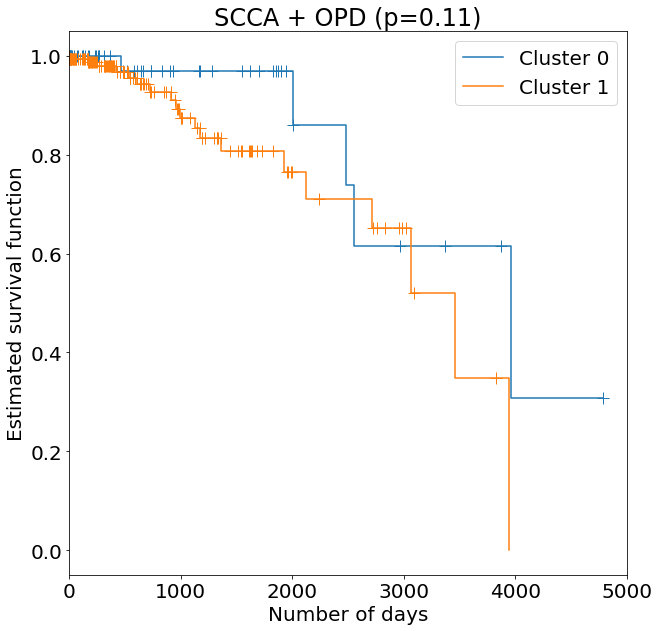

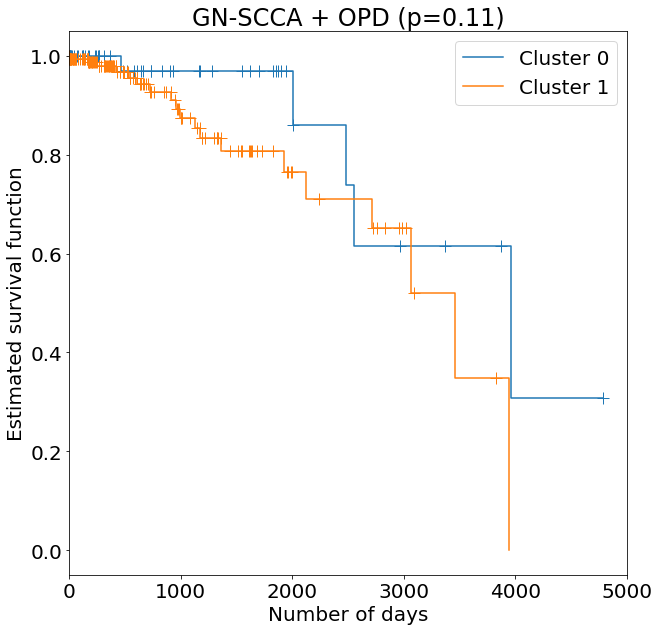

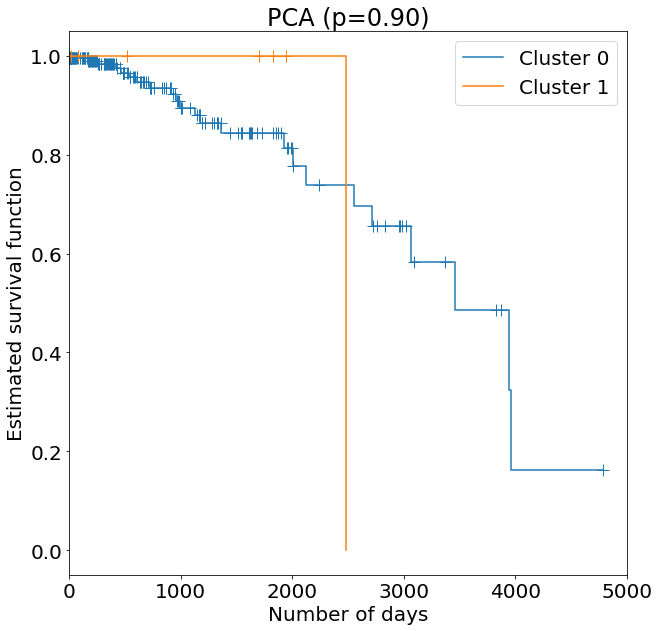

In [237]:
fold=0
for method in ['scca', 'gnscca', 'pca_concat']:
    brca = Dataset(num_genes, fold, suffix)
    features, labels = brca.feature_generator(method, prior, deflation)

    events_train = [x for (x,y) in labels['train']]
    times_train = [y for (x,y) in labels['train']]

    events_test = [x for (x,y) in labels['test']]
    times_test = [y for (x,y) in labels['test']]

    print("Full length", len(events_test))

    if method == 'scca':
        X_train = features['train'][2]
        X_test = features['test'][2]
    elif method == 'pca_concat':
        X_train = features['train']
        X_test = features['test']

    gmm = GaussianMixture(n_components=n_clusters, random_state=random_seed)
    gmm_fit = gmm.fit(X_train)
    gmm_clusters = gmm_fit.fit_predict(X_test)

    plt.figure(figsize=(10,10)) 

    times_curr = {}
    events_curr = {}
    kms = {}
    list_of_ids = []
        
    for cluster_id in list(set(gmm_clusters)):
        
        cluster_0 = X_test[gmm_clusters==cluster_id]
        
        print("Cluster lengths", len(cluster_0))
        list_of_ids.append(cluster_id)
       
        times_curr[cluster_id] = np.array(times_test)[gmm_clusters==cluster_id]
        events_curr[cluster_id] = np.array(events_test)[gmm_clusters==cluster_id]

        all_km = generate_km_curve(times_curr[cluster_id], events_curr[cluster_id])
        kms[cluster_id] = all_km

        all_km.plot(show_censors=True, label="Cluster " + str(cluster_id), ci_alpha=0)
        plt.xlim(0, 5000)
        plt.xlabel("Number of days")
        plt.ylabel("Estimated survival function")
        
    print(print_titles[method])

    results = pairwise_logrank_test(np.array(times_test), 
                                    gmm_clusters, 
                                    np.array(events_test))
    plt.title(print_titles[method] + " (p={0:1.2f})".format(results.p_value[0]))
        
    results.print_summary()

